#retinanetの実行テスト

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd drive/My Drive/Colab Notebooks/ジャンクション

/content/drive/My Drive/Colab Notebooks/ジャンクション


In [0]:
cd retinanet/keras-retinanet

/content/drive/My Drive/Colab Notebooks/ジャンクション/retinanet/keras-retinanet


In [0]:
!python setup.py build_ext --inplace

running build_ext
cythoning keras_retinanet/utils/compute_overlap.pyx to keras_retinanet/utils/compute_overlap.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/drive/My Drive/Colab Notebooks/ジャンクション/retinanet/keras-retinanet/keras_retinanet/utils/compute_overlap.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'keras_retinanet.utils.compute_overlap' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/keras_retinanet
creating build/temp.linux-x86_64-3.6/keras_retinanet/utils
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.6m -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -c keras_retinanet/utils/compute_overlap.c -o build/temp.li



#必要なモジュールの読み込み



In [0]:
# show images inline（画像をインラインで表示する）
%matplotlib inline

# automatically reload modules when they have changed（モジュールが変更されたら自動的にロードする）
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time
import collections as cl
import json

# set tf backend to allow memory to grow, instead of claiming everything（tfバックエンドを設定して、すべてを要求するのではなく、メモリを増やせるようにする）
import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# use this environment flag to change which GPU to use（使用するGPUを変更するには、この環境フラグを使用してください。）
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# set the modified tf session as backend in keras（変更したtfセッションをkerasのバックエンドとして設定します）
keras.backend.tensorflow_backend.set_session(get_session())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#RetinaNetモデルの読み込み

In [0]:
# adjust this to point to your downloaded/trained model（ダウンロード/トレーニングしたモデルを指すように調整してください。）
# models can be downloaded here: https://github.com/fizyr/keras-retinanet/releases（モデルはこちらからダウンロードできます：https：//github.com/fizyr/keras-retinanet/releases）
#model_path = os.path.join('..', 'snapshots', 'resnet50_coco_best_v2.1.0.h5')
model_path=('resnet50_coco_best_v2.1.0.h5')

# load retinanet model
model =models. load_model(model_path, backbone_name='resnet50')

# if the model is not converted to an inference model, use the line below（モデルが推論モデルに変換されていない場合は、以下の行を使用してください。）
# see: https://github.com/fizyr/keras-retinanet#converting-a-training-model-to-inference-model
#model = models.convert_model(model)

#print(model.summary())

# load label to names mapping for visualization purposes（load label to names mapping for visualization purposes）
labels_to_names = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


#検出の実行例

processing time:  4.221651792526245
person 0.835815 [440.09778 155.81964 831.1803  611.57385]
person 0.8152847 [ 14.266677 199.29004  385.8607   663.8669  ]
person 0.66679984 [286.68768 140.19725 486.23376 624.0086 ]
person 0.6264473 [599.51935   25.692663 903.07434  516.40045 ]
person 0.61987835 [532.62836  64.3284  734.3529  332.55573]
cell phone 0.59793293 [338.5739  223.63405 382.29343 289.22897]
person 0.58973783 [446.85608   75.478836 545.6683   213.21167 ]
sports ball 0.5819856 [437.5843  610.54266 491.71655 661.65674]
person 0.505469 [159.44632 157.21358 436.27225 634.4087 ]
make result_file


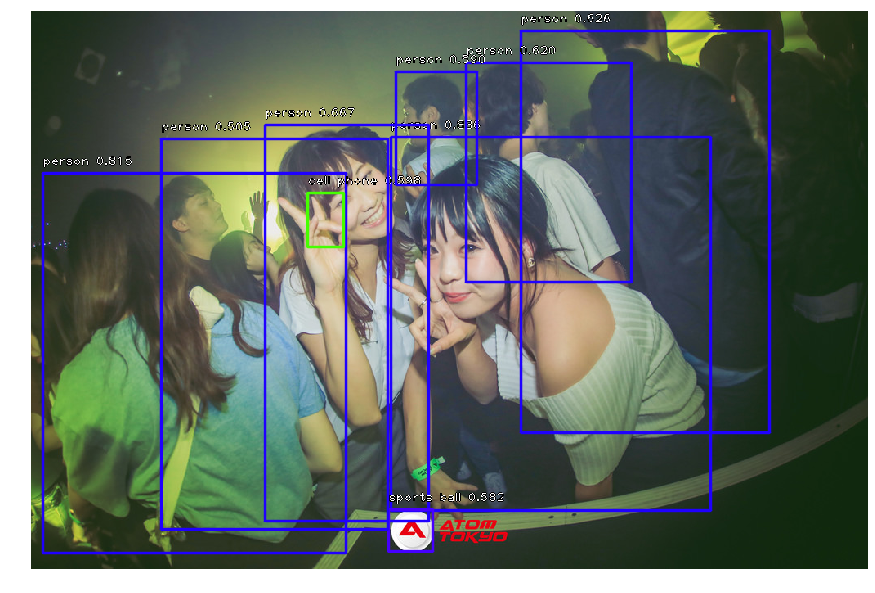

In [0]:
# 解析対象画像のパス
dir_path='test_images'
image_path='1'
input_image_path=os.path.join(dir_path, image_path+'.jpg')
image = read_image_bgr(input_image_path)

# 最後に描画するためにコピーしておく
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network（kerasのpreprocessを使って、画像の前処理を行う）
image = preprocess_image(image)#前処理
image, scale = resize_image(image)#input_shapeに合わせリサイズ

# process image（予測に掛かる時間計測）
start = time.time()
boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))#予測結果が入る部分
print("processing time: ", time.time() - start)

# correct for image scale（画像の縮尺を補正する）
boxes /= scale

#テキストファイル書き出し用、配列
output_scores=cl.OrderedDict()
i=0

# visualize detections（検出された領域を表示する）
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < 0.5:
        break

    color = label_color(label)
    
    b = box.astype(int)
    draw_box(draw, b, color=color)
    
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(draw, b, caption)
    
    print(labels_to_names[label],score,box)#領域、確信度、ラベルを画面に表示する
    box = [str(i) for i in box]#文字列結合できるようbox配列内の数字を文字列型に変換
    output_scores[i]=cl.OrderedDict({"label":labels_to_names[label],"score":float(score),"box":",".join(box)})#辞書型に格納
    i+=1

i=0
result_dir_path=os.path.join('results',image_path+'_result')#結果出力ディレクトリ設定
if(os.path.exists(str(result_dir_path))==False):#ディレクトリが存在しないとき、ディレクトリ作成
    os.mkdir(str(result_dir_path))
    print("make result_file")

result_json_path=os.path.join(str(result_dir_path),image_path+'_result.json')#出力されるjsonファイルのパス
f=open(result_json_path,'w')
json.dump(output_scores,f)#jsonファイル書き出し
f.close()
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
result_image_path=os.path.join(str(result_dir_path),image_path+'_result.png')#出力される画像ファイルのパス
plt.savefig(result_image_path)#matplotの結果を画像ファイルに書き出し
plt.show()

